In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:41 - loss: 0.0896 - STD: 2.8133e-04 - MAE: 0.2883

 4/64 [>.............................] - ETA: 1s - loss: 0.0377 - STD: 3.4339e-04 - MAE: 0.1482  

 5/64 [=>............................] - ETA: 2s - loss: 0.0369 - STD: 3.0851e-04 - MAE: 0.1477

 6/64 [=>............................] - ETA: 2s - loss: 0.0366 - STD: 2.7796e-04 - MAE: 0.1480

 7/64 [==>...........................] - ETA: 2s - loss: 0.0362 - STD: 2.5254e-04 - MAE: 0.1478

 8/64 [==>...........................] - ETA: 3s - loss: 0.0355 - STD: 2.3212e-04 - MAE: 0.1465

 9/64 [===>..........................] - ETA: 3s - loss: 0.0346 - STD: 2.1689e-04 - MAE: 0.1439

10/64 [===>..........................] - ETA: 3s - loss: 0.0335 - STD: 2.0634e-04 - MAE: 0.1400

11/64 [====>.........................] - ETA: 3s - loss: 0.0322 - STD: 1.9998e-04 - MAE: 0.1348

12/64 [====>.........................] - ETA: 3s - loss: 0.0307 - STD: 1.9721e-04 - MAE: 0.1289

13/64 [=====>........................] - ETA: 3s - loss: 0.0293 - STD: 1.9713e-04 - MAE: 0.1238

14/64 [=====>........................] - ETA: 3s - loss: 0.0282 - STD: 1.9887e-04 - MAE: 0.1208

15/64 [======>.......................] - ETA: 2s - loss: 0.0273 - STD: 2.0189e-04 - MAE: 0.1196

16/64 [======>.......................] - ETA: 2s - loss: 0.0267 - STD: 2.0520e-04 - MAE: 0.1194

17/64 [======>.......................] - ETA: 2s - loss: 0.0262 - STD: 2.0858e-04 - MAE: 0.1196

18/64 [=======>......................] - ETA: 2s - loss: 0.0258 - STD: 2.1195e-04 - MAE: 0.1197

19/64 [=======>......................] - ETA: 2s - loss: 0.0253 - STD: 2.1478e-04 - MAE: 0.1192

20/64 [========>.....................] - ETA: 2s - loss: 0.0248 - STD: 2.1724e-04 - MAE: 0.1182

21/64 [========>.....................] - ETA: 4s - loss: 0.0247 - STD: 2.1886e-04 - MAE: 0.1165

24/64 [==========>...................] - ETA: 3s - loss: 0.0231 - STD: 2.2228e-04 - MAE: 0.1100

26/64 [===========>..................] - ETA: 3s - loss: 0.0225 - STD: 2.2365e-04 - MAE: 0.1063

27/64 [===========>..................] - ETA: 2s - loss: 0.0222 - STD: 2.2443e-04 - MAE: 0.1047

28/64 [============>.................] - ETA: 2s - loss: 0.0219 - STD: 2.2548e-04 - MAE: 0.1032

29/64 [============>.................] - ETA: 2s - loss: 0.0216 - STD: 2.2689e-04 - MAE: 0.1017

30/64 [=============>................] - ETA: 2s - loss: 0.0214 - STD: 2.2873e-04 - MAE: 0.1003

31/64 [=============>................] - ETA: 2s - loss: 0.0211 - STD: 2.3109e-04 - MAE: 0.0991

32/64 [==============>...............] - ETA: 2s - loss: 0.0208 - STD: 2.3389e-04 - MAE: 0.0980

33/64 [==============>...............] - ETA: 2s - loss: 0.0206 - STD: 2.3711e-04 - MAE: 0.0971

34/64 [==============>...............] - ETA: 2s - loss: 0.0204 - STD: 2.4081e-04 - MAE: 0.0966

35/64 [===============>..............] - ETA: 2s - loss: 0.0202 - STD: 2.4489e-04 - MAE: 0.0961

36/64 [===============>..............] - ETA: 2s - loss: 0.0200 - STD: 2.4920e-04 - MAE: 0.0959

37/64 [================>.............] - ETA: 2s - loss: 0.0198 - STD: 2.5370e-04 - MAE: 0.0956

38/64 [================>.............] - ETA: 1s - loss: 0.0196 - STD: 2.5828e-04 - MAE: 0.0954

39/64 [=================>............] - ETA: 1s - loss: 0.0194 - STD: 2.6288e-04 - MAE: 0.0951

40/64 [=================>............] - ETA: 1s - loss: 0.0193 - STD: 2.6735e-04 - MAE: 0.0948

41/64 [==================>...........] - ETA: 1s - loss: 0.0191 - STD: 2.7189e-04 - MAE: 0.0943

42/64 [==================>...........] - ETA: 1s - loss: 0.0190 - STD: 2.7621e-04 - MAE: 0.0938

43/64 [===================>..........] - ETA: 1s - loss: 0.0189 - STD: 2.8043e-04 - MAE: 0.0932

44/64 [===================>..........] - ETA: 1s - loss: 0.0187 - STD: 2.8475e-04 - MAE: 0.0926

45/64 [====================>.........] - ETA: 1s - loss: 0.0185 - STD: 2.8896e-04 - MAE: 0.0919

46/64 [====================>.........] - ETA: 1s - loss: 0.0184 - STD: 2.9346e-04 - MAE: 0.0913

47/64 [=====================>........] - ETA: 1s - loss: 0.0183 - STD: 2.9803e-04 - MAE: 0.0906

48/64 [=====================>........] - ETA: 1s - loss: 0.0182 - STD: 3.0292e-04 - MAE: 0.0901

49/64 [=====================>........] - ETA: 1s - loss: 0.0181 - STD: 3.0788e-04 - MAE: 0.0895

50/64 [======================>.......] - ETA: 0s - loss: 0.0180 - STD: 3.1328e-04 - MAE: 0.0890

51/64 [======================>.......] - ETA: 0s - loss: 0.0179 - STD: 3.1916e-04 - MAE: 0.0886

52/64 [=======================>......] - ETA: 0s - loss: 0.0178 - STD: 3.2535e-04 - MAE: 0.0883

53/64 [=======================>......] - ETA: 0s - loss: 0.0177 - STD: 3.3196e-04 - MAE: 0.0880

54/64 [========================>.....] - ETA: 0s - loss: 0.0176 - STD: 3.3888e-04 - MAE: 0.0877

55/64 [========================>.....] - ETA: 0s - loss: 0.0175 - STD: 3.4599e-04 - MAE: 0.0875

56/64 [=========================>....] - ETA: 0s - loss: 0.0174 - STD: 3.5361e-04 - MAE: 0.0873

57/64 [=========================>....] - ETA: 0s - loss: 0.0173 - STD: 3.6135e-04 - MAE: 0.0870

58/64 [==========================>...] - ETA: 0s - loss: 0.0172 - STD: 3.6931e-04 - MAE: 0.0868

59/64 [==========================>...] - ETA: 0s - loss: 0.0171 - STD: 3.7748e-04 - MAE: 0.0866

60/64 [===========================>..] - ETA: 0s - loss: 0.0171 - STD: 3.8585e-04 - MAE: 0.0863

61/64 [===========================>..] - ETA: 0s - loss: 0.0170 - STD: 3.9451e-04 - MAE: 0.0861

62/64 [============================>.] - ETA: 0s - loss: 0.0169 - STD: 4.0328e-04 - MAE: 0.0858

63/64 [============================>.] - ETA: 0s - loss: 0.0168 - STD: 4.1232e-04 - MAE: 0.0855

64/64 [==============================] - ETA: 0s - loss: 0.0168 - STD: 4.2161e-04 - MAE: 0.0852

64/64 [==============================] - 7s 79ms/step - loss: 0.0168 - STD: 4.2161e-04 - MAE: 0.0852 - val_loss: 0.0168 - val_STD: 7.6102e-04 - val_MAE: 0.0754


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0655

 2/64 [..............................] - ETA: 3s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0661

 3/64 [>.............................] - ETA: 3s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0662

 4/64 [>.............................] - ETA: 3s - loss: 0.0124 - STD: 0.0011 - MAE: 0.0664

 5/64 [=>............................] - ETA: 3s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0670

 6/64 [=>............................] - ETA: 3s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0675

 7/64 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0681

 8/64 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0685

 9/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0688

10/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0692

11/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0694

12/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0697

13/64 [=====>........................] - ETA: 2s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0698

14/64 [=====>........................] - ETA: 2s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0698

15/64 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0697

16/64 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0696

17/64 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0695

18/64 [=======>......................] - ETA: 2s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0694

19/64 [=======>......................] - ETA: 2s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0694

20/64 [========>.....................] - ETA: 2s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0693

21/64 [========>.....................] - ETA: 2s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0693

22/64 [=========>....................] - ETA: 2s - loss: 0.0125 - STD: 0.0019 - MAE: 0.0693

23/64 [=========>....................] - ETA: 2s - loss: 0.0125 - STD: 0.0019 - MAE: 0.0693

24/64 [==========>...................] - ETA: 2s - loss: 0.0124 - STD: 0.0020 - MAE: 0.0692

25/64 [==========>...................] - ETA: 2s - loss: 0.0125 - STD: 0.0020 - MAE: 0.0693

26/64 [===========>..................] - ETA: 2s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0693

27/64 [===========>..................] - ETA: 2s - loss: 0.0124 - STD: 0.0022 - MAE: 0.0692

28/64 [============>.................] - ETA: 2s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0692

29/64 [============>.................] - ETA: 2s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0692

30/64 [=============>................] - ETA: 1s - loss: 0.0124 - STD: 0.0024 - MAE: 0.0691

31/64 [=============>................] - ETA: 1s - loss: 0.0124 - STD: 0.0025 - MAE: 0.0691

32/64 [==============>...............] - ETA: 1s - loss: 0.0124 - STD: 0.0026 - MAE: 0.0691

33/64 [==============>...............] - ETA: 1s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0691

34/64 [==============>...............] - ETA: 1s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0690

35/64 [===============>..............] - ETA: 1s - loss: 0.0123 - STD: 0.0030 - MAE: 0.0689

37/64 [================>.............] - ETA: 1s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0689

38/64 [================>.............] - ETA: 1s - loss: 0.0123 - STD: 0.0034 - MAE: 0.0688

39/64 [=================>............] - ETA: 1s - loss: 0.0123 - STD: 0.0035 - MAE: 0.0688

40/64 [=================>............] - ETA: 1s - loss: 0.0122 - STD: 0.0037 - MAE: 0.0688

41/64 [==================>...........] - ETA: 1s - loss: 0.0122 - STD: 0.0039 - MAE: 0.0687

42/64 [==================>...........] - ETA: 1s - loss: 0.0122 - STD: 0.0041 - MAE: 0.0686

43/64 [===================>..........] - ETA: 1s - loss: 0.0122 - STD: 0.0043 - MAE: 0.0685

44/64 [===================>..........] - ETA: 1s - loss: 0.0121 - STD: 0.0045 - MAE: 0.0684

45/64 [====================>.........] - ETA: 1s - loss: 0.0121 - STD: 0.0047 - MAE: 0.0683

46/64 [====================>.........] - ETA: 1s - loss: 0.0120 - STD: 0.0049 - MAE: 0.0682

47/64 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 0.0052 - MAE: 0.0681

48/64 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 0.0055 - MAE: 0.0679

49/64 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 0.0058 - MAE: 0.0678

50/64 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 0.0061 - MAE: 0.0676

51/64 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.0065 - MAE: 0.0675

52/64 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0069 - MAE: 0.0674

53/64 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0073 - MAE: 0.0672

54/64 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.0077 - MAE: 0.0671

55/64 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.0081 - MAE: 0.0669

56/64 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0086 - MAE: 0.0667

57/64 [=========================>....] - ETA: 0s - loss: 0.0115 - STD: 0.0091 - MAE: 0.0665

58/64 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0097 - MAE: 0.0663

59/64 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0103 - MAE: 0.0661

60/64 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.0109 - MAE: 0.0659

61/64 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.0115 - MAE: 0.0656

62/64 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0121 - MAE: 0.0654

63/64 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0128 - MAE: 0.0651

64/64 [==============================] - ETA: 0s - loss: 0.0110 - STD: 0.0135 - MAE: 0.0648

64/64 [==============================] - 4s 61ms/step - loss: 0.0110 - STD: 0.0135 - MAE: 0.0648 - val_loss: 0.0083 - val_STD: 0.0418 - val_MAE: 0.0538


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0464

 2/64 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0602 - MAE: 0.0466

 3/64 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0468

 4/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0464

 5/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0462

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0696 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0707 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0719 - MAE: 0.0446

13/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0441

14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0745 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0436

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0760 - MAE: 0.0434

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0770 - MAE: 0.0431

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0778 - MAE: 0.0430

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0428

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0426

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0794 - MAE: 0.0424

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0422

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0421

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0419

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0417

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0823 - MAE: 0.0416

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0827 - MAE: 0.0414

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0831 - MAE: 0.0413

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0835 - MAE: 0.0411

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0838 - MAE: 0.0410

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0841 - MAE: 0.0408

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0407

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0406

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0854 - MAE: 0.0405

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0403

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0860 - MAE: 0.0402

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0863 - MAE: 0.0401

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0866 - MAE: 0.0400

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0869 - MAE: 0.0399

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0871 - MAE: 0.0398

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0875 - MAE: 0.0397

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0878 - MAE: 0.0396

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0880 - MAE: 0.0395

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0882 - MAE: 0.0395

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0884 - MAE: 0.0394

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0886 - MAE: 0.0393

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0888 - MAE: 0.0392

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0391

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0891 - MAE: 0.0390

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0389

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0896 - MAE: 0.0388

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0898 - MAE: 0.0387

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0899 - MAE: 0.0386

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0386

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0903 - MAE: 0.0385

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0904 - MAE: 0.0384

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0906 - MAE: 0.0383

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0908 - MAE: 0.0383

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0910 - MAE: 0.0382

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0912 - MAE: 0.0381

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0381

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0913 - MAE: 0.0380

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0915 - MAE: 0.0379

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0916 - MAE: 0.0379

64/64 [==============================] - 4s 62ms/step - loss: 0.0035 - STD: 0.0916 - MAE: 0.0379 - val_loss: 0.0030 - val_STD: 0.0768 - val_MAE: 0.0365


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0338

 2/64 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0999 - MAE: 0.0336

 3/64 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1004 - MAE: 0.0335

 4/64 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0331

 5/64 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1003 - MAE: 0.0331

 6/64 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0332

 7/64 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0332

 8/64 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0332

 9/64 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0332

11/64 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0332

12/64 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0331

13/64 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0331

14/64 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

15/64 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

16/64 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0330

17/64 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0329

18/64 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0329

19/64 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0329

20/64 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0328

21/64 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0328

22/64 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0327

23/64 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0327

24/64 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0327

25/64 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0327

26/64 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0326

27/64 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0326

28/64 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1008 - MAE: 0.0326

29/64 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0325

30/64 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0325

31/64 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0325

32/64 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0324

33/64 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0324

34/64 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0323

35/64 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0323

36/64 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0323

37/64 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0322

38/64 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0322

39/64 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0322

40/64 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0322

41/64 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0321

42/64 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0321

43/64 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0321

44/64 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0321

45/64 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0320

46/64 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

47/64 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

48/64 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0320

49/64 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0320

50/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0319

51/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0319

52/64 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0319

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0319

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

55/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

58/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

59/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317

61/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317

63/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0317

64/64 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317

64/64 [==============================] - 4s 60ms/step - loss: 0.0022 - STD: 0.1014 - MAE: 0.0317 - val_loss: 0.0025 - val_STD: 0.0862 - val_MAE: 0.0332


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0303

 2/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0302

 3/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0304

 4/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0304

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0305

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0304

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0305

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0305

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

13/64 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

14/64 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

15/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

16/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

17/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

18/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0304

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0305

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

30/64 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

31/64 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

32/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

33/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

47/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0302

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0302

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0302

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

64/64 [==============================] - 4s 60ms/step - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301 - val_loss: 0.0024 - val_STD: 0.0905 - val_MAE: 0.0323


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0293

 2/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0294

 3/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0296

 4/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0296

 5/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0296

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0296

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0296

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0296

14/64 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

15/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

16/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

17/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

18/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

30/64 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

31/64 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

32/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

33/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

48/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0296

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

64/64 [==============================] - 4s 62ms/step - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296 - val_loss: 0.0023 - val_STD: 0.0908 - val_MAE: 0.0317


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0290

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0290

 3/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0288

 5/64 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0290

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0290

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

10/64 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0289

11/64 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0289

12/64 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

13/64 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0289

14/64 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0289

15/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

16/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

17/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0288

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0288

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

31/64 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

32/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0287

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0287

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

64/64 [==============================] - 4s 62ms/step - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287 - val_loss: 0.0023 - val_STD: 0.0928 - val_MAE: 0.0312


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

12/64 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

13/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

14/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

28/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

29/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

64/64 [==============================] - 4s 64ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282 - val_loss: 0.0022 - val_STD: 0.0926 - val_MAE: 0.0308


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0280

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0279

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0281

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

14/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

64/64 [==============================] - 4s 63ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279 - val_loss: 0.0021 - val_STD: 0.0933 - val_MAE: 0.0302


Epoch 10/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0275

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0277

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0281

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0281

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0281

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0284

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0283

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0284

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0286

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0289

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0289

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0291

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0291

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0291

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

64/64 [==============================] - 4s 68ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289 - val_loss: 0.0022 - val_STD: 0.0931 - val_MAE: 0.0306


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0277

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0275

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0275

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0275

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0274

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

64/64 [==============================] - 4s 66ms/step - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274 - val_loss: 0.0022 - val_STD: 0.0954 - val_MAE: 0.0302


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0277

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0273

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272 - val_loss: 0.0021 - val_STD: 0.0950 - val_MAE: 0.0296


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0273

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0271

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0270

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0270

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

64/64 [==============================] - 4s 70ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277 - val_loss: 0.0020 - val_STD: 0.0904 - val_MAE: 0.0302


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0992 - MAE: 0.0281

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0287

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0280

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0280

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0279

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0946 - val_MAE: 0.0293


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - 4s 67ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271 - val_loss: 0.0029 - val_STD: 0.0996 - val_MAE: 0.0349


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1124 - MAE: 0.0318

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0313

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

 4/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1070 - MAE: 0.0308

 5/64 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0302

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0300

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0302

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0297

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0298

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0295

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0296

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0296

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0294

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0294

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0292

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0289

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0288

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0287

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - 4s 70ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0942 - val_MAE: 0.0289


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0266

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0264

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264 - val_loss: 0.0022 - val_STD: 0.0976 - val_MAE: 0.0300


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0948 - val_MAE: 0.0286


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0939 - val_MAE: 0.0284


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0266

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0020 - val_STD: 0.0966 - val_MAE: 0.0289


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0259

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0267

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0970 - val_MAE: 0.0287


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0262

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0932 - val_MAE: 0.0287


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0948 - val_MAE: 0.0282


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0258

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0260

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0259

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 5s 70ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0941 - val_MAE: 0.0283


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0257

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0949 - val_MAE: 0.0281


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1012 - MAE: 0.0251

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0254

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0929 - val_MAE: 0.0281


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0936 - val_MAE: 0.0282


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0261

 4/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0981 - val_MAE: 0.0288


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1094 - MAE: 0.0256

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0259

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0978 - val_MAE: 0.0283


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0021 - val_STD: 0.0987 - val_MAE: 0.0297


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0946 - val_MAE: 0.0277


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0020 - val_STD: 0.0971 - val_MAE: 0.0284


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1098 - MAE: 0.0251

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0926 - val_MAE: 0.0279


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0019 - val_STD: 0.0968 - val_MAE: 0.0281


Epoch 35/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0250

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0251

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254 - val_loss: 0.0019 - val_STD: 0.0975 - val_MAE: 0.0285


Epoch 36/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0247

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0249

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0018 - val_STD: 0.0958 - val_MAE: 0.0276


Epoch 37/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0247

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0251

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0022 - val_STD: 0.0990 - val_MAE: 0.0300


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1098 - MAE: 0.0262

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0024 - val_STD: 0.1011 - val_MAE: 0.0314


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255 - val_loss: 0.0020 - val_STD: 0.0991 - val_MAE: 0.0285


Epoch 40/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1090 - MAE: 0.0247

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0247

 4/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0248

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0249

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0249

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0249

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0248

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249 - val_loss: 0.0017 - val_STD: 0.0949 - val_MAE: 0.0275


Epoch 41/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1043 - MAE: 0.0244

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0247

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0250

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0254

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 4s 70ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252 - val_loss: 0.0019 - val_STD: 0.0983 - val_MAE: 0.0281


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1089 - MAE: 0.0248

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0019 - val_STD: 0.0974 - val_MAE: 0.0279


Epoch 43/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1084 - MAE: 0.0246

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1089 - MAE: 0.0246

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1084 - MAE: 0.0246

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0247

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252 - val_loss: 0.0019 - val_STD: 0.0990 - val_MAE: 0.0280


Epoch 44/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0247

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0247

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250 - val_loss: 0.0020 - val_STD: 0.0982 - val_MAE: 0.0288


Epoch 45/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1145 - MAE: 0.0252

 2/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0257

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - 4s 70ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0020 - val_STD: 0.0982 - val_MAE: 0.0286


Epoch 46/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1093 - MAE: 0.0250

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0245

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0245

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - 4s 69ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248 - val_loss: 0.0024 - val_STD: 0.1013 - val_MAE: 0.0316


Epoch 47/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1141 - MAE: 0.0274

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0271

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0258

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - 4s 68ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0018 - val_STD: 0.0976 - val_MAE: 0.0275


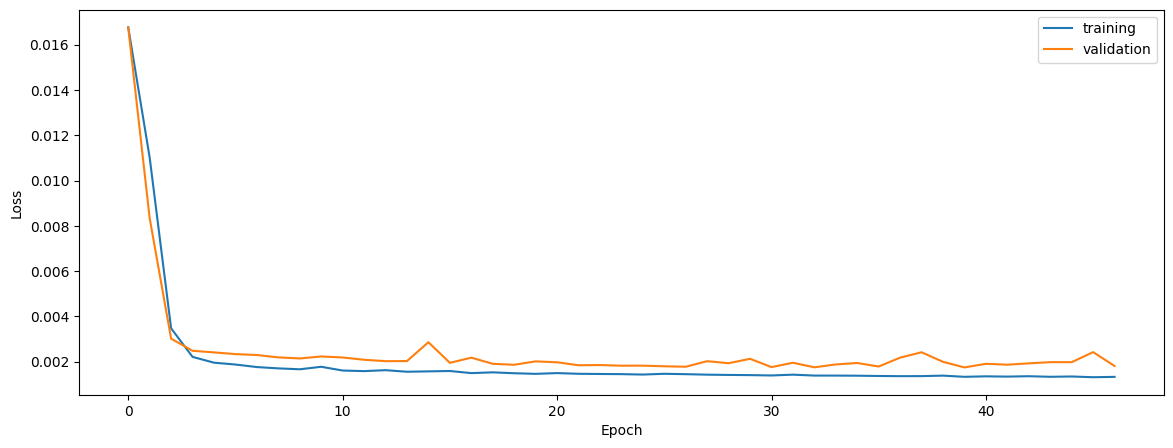

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


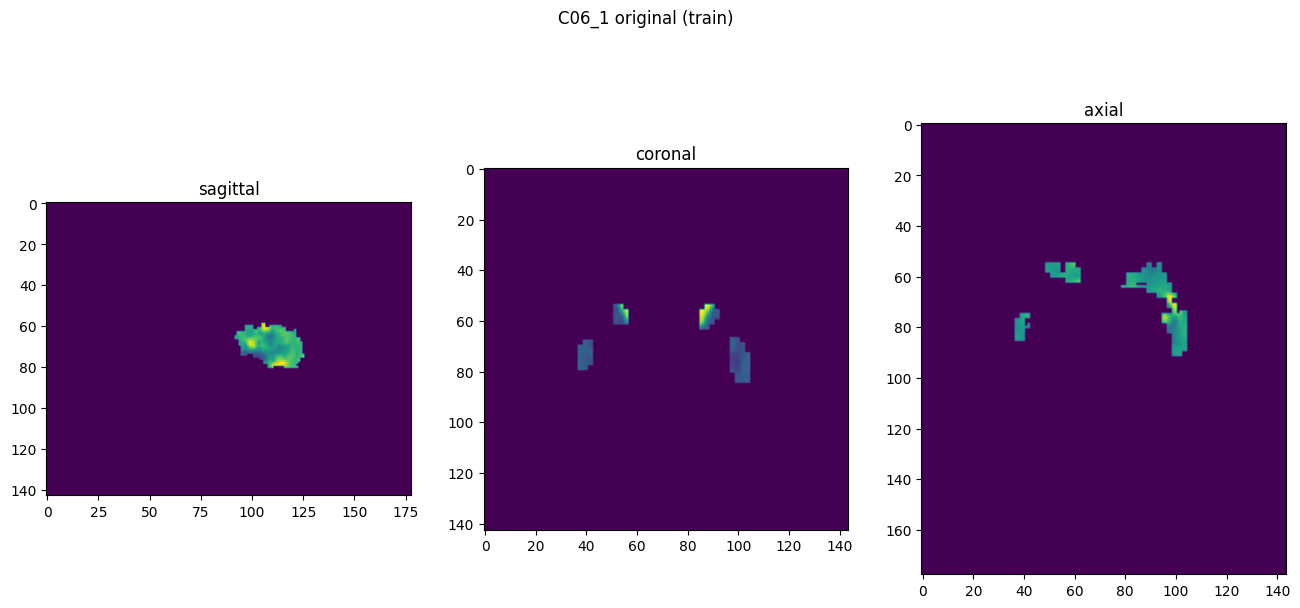

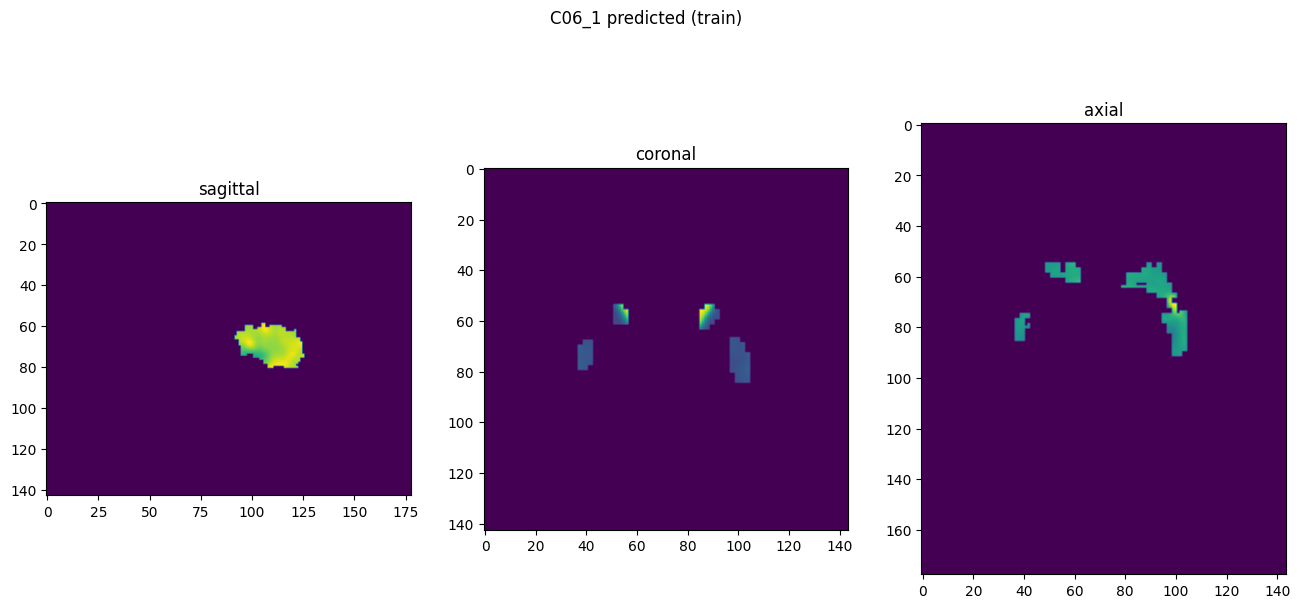

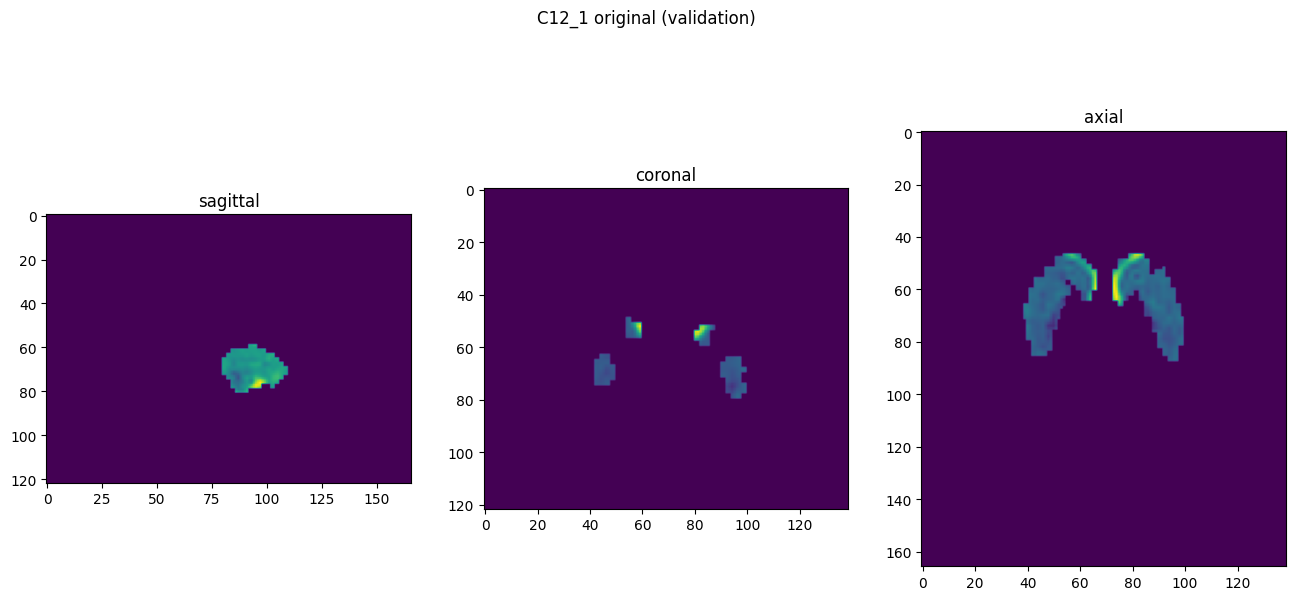

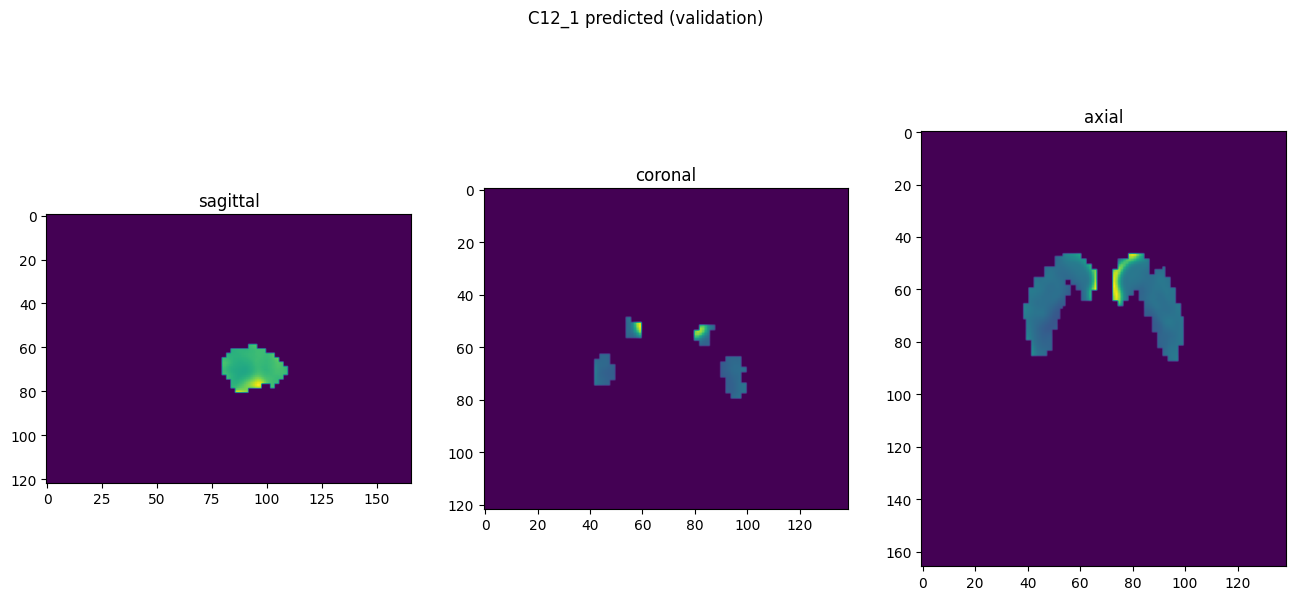

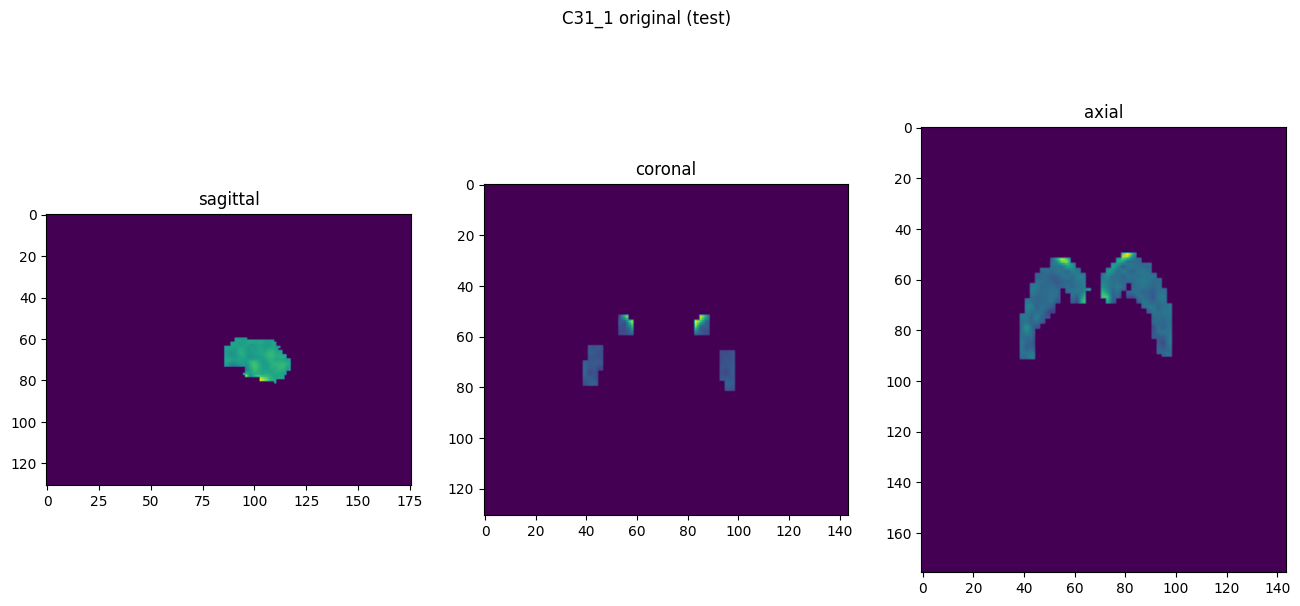

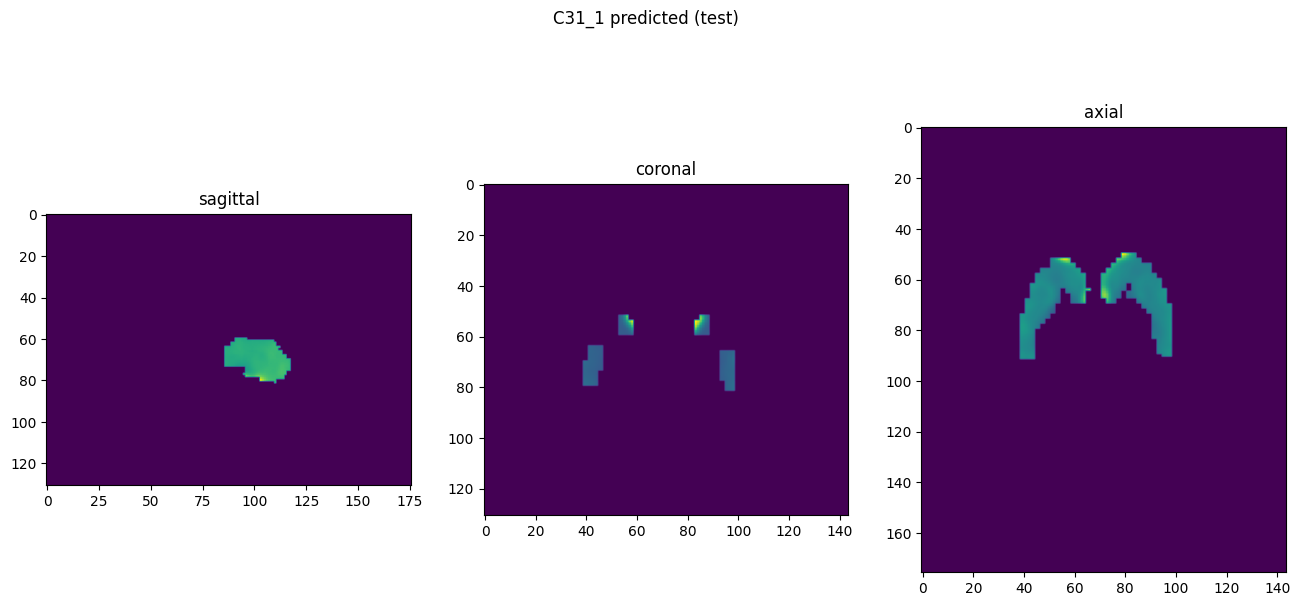

In [10]:
showResults(model, gen, threshold=None, background=False)